In [220]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from datetime import date
import calendar

Read in dataframe, clean up index and datetime info, set X and Y for regression
Split into test/train sets, normalize features, perform linear regression
Check model metrics using predictions with test set

In [208]:
df2 = pd.read_csv('uncertainty.csv')
df2.rename(columns = {"Unnamed: 0": "Date"}, inplace = True) 
df2 = df2.set_index('Date')
df2.index = pd.to_datetime(df2.index)
df2.dropna(inplace = True) 
df2 = pd.get_dummies(df2, columns = ['Month', 'Hour', 'Day'], drop_first = True)
df2.head(3)

reg = LinearRegression()
X = df2.drop(['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48'], axis = 1)
X_norm = preprocessing.normalize(X)
y = df2[['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']]
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.3, random_state = 21)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
cv_results = cross_val_score(reg, X, y, cv = 5)
print(cv_results)
print(r2_score(y_test, y_pred))
mean_squared_error(y_test, y_pred)

[0.70126876 0.68045405 0.73500357 0.66591282 0.7307141 ]
0.7209664640289674


//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
//anaconda3/envs/insight/lib/python3.7/site-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput=

0.00010564489932220906

In [209]:
#RMSE as percentage of average ozone level
mean_squared_error(y_test, y_pred)**(.5)/(df2['Ozone'].mean()) * 100

28.46134436665212

In [210]:
#extract features for each future prediction
X.columns
df_importance = pd.DataFrame(X.columns, columns = ['features'])
df_importance['importance+8'] = reg.coef_[0]
df_importance['importance+16'] = reg.coef_[1]
df_importance['importance+24'] = reg.coef_[2]
df_importance['importance+32'] = reg.coef_[3]
df_importance['importance+40'] = reg.coef_[4]
df_importance['importance+48'] = reg.coef_[5]
df_abs = df_importance.set_index('features')
df_abs = df_abs.abs().sort_values(by ='importance+48', ascending = False)
df_abs

,importance+8,importance+16,importance+24,importance+32,importance+40,importance+48
features,,,,,,
Ozone,707.257763,164.462175,1649.803503,357.539432,151.523527,933.014550
Ozone-24,389.960023,17.881457,135.443786,174.290805,69.629246,209.713420
Ozone-16,1553.516337,33.453492,114.036801,950.101941,43.015535,142.083434
Hour_8,33.207244,12.678842,33.636077,29.260265,27.478331,57.755349
Month_Dec,21.298419,30.215407,31.068054,37.900685,42.077911,39.230003
...,...,...,...,...,...,...
Humidity-24,0.014894,0.104960,0.035618,0.045701,0.176479,0.033097
Wind Speed+16,0.016776,2.248378,1.088321,0.198242,0.578069,0.024656
Humidity+8,0.140980,0.047935,0.061140,0.035274,0.038917,0.024291


<function matplotlib.pyplot.show(*args, **kw)>

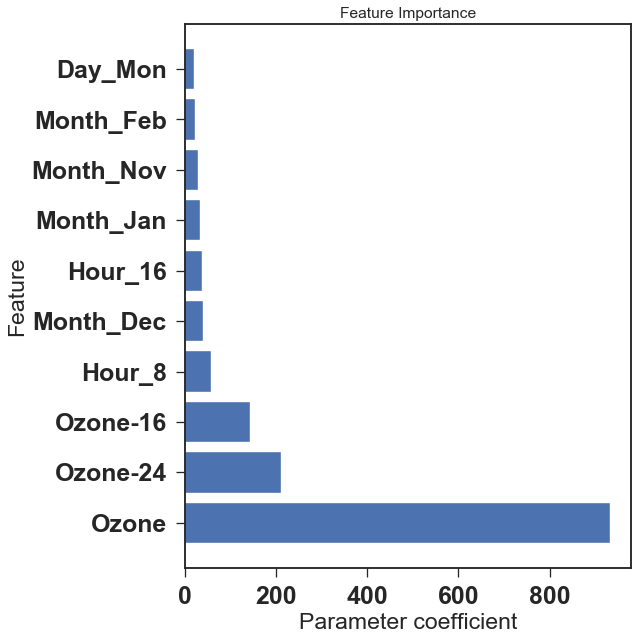

In [211]:
#use matplotlib to plot importance
fig, ax = plt.subplots(figsize=(8, 10))
plt.style.use('seaborn-talk')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
ax.barh(df_abs.index[:10], df_abs['importance+48'][:10])
ax.set(title = 'Feature Importance',
       xlabel = 'Parameter coefficient',
      ylabel = 'Feature')
plt.show
#plt.savefig('year_line_plots2.png')

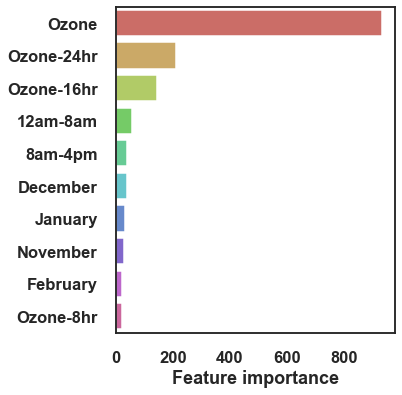

In [213]:
#use seaborn to plot importance
#representative plot showing feature importance - +48 hours

import seaborn as sns
sns.set_style("white")
sns.set_context('talk')
df_abs.reset_index(inplace = True)
f, ax = plt.subplots(figsize = (5,6))
g = sns.barplot(x='importance+48', y = 'features', data = df_abs[:10], palette=("hls"))
g.set(yticklabels=['Ozone', 'Ozone-24hr', 'Ozone-16hr', '12am-8am', '8am-4pm', 
                   'December', 'January', 'November', 'February', 'Ozone-8hr'])
plt.xlabel("Feature importance", weight='bold')
plt.ylabel("")
plt.show
plt.savefig('feature_importance.png', bbox_inches = "tight")

In [214]:
#organize model output into organized dataframe
output = pd.DataFrame(data=y_pred[:,:])
output.columns = ['Ozone+8', 'Ozone+16', 'Ozone+24', 'Ozone+32', 'Ozone+40', 'Ozone+48']
output.index = y_test.index
output.head()

,Ozone+8,Ozone+16,Ozone+24,Ozone+32,Ozone+40,Ozone+48
Date,,,,,,
2016-11-19 00:00:00,0.036718,0.023102,0.005269,0.036226,0.020941,0.011102
2016-12-20 00:00:00,0.039154,0.021338,0.011739,0.034792,0.025751,0.008082
2016-07-03 16:00:00,0.025851,0.051683,0.038353,0.021236,0.047537,0.041249
2017-11-29 08:00:00,0.022604,-0.001372,0.032592,0.029057,0.006534,0.033846
2017-10-11 00:00:00,0.045071,0.037605,0.011009,0.043001,0.038329,0.015565


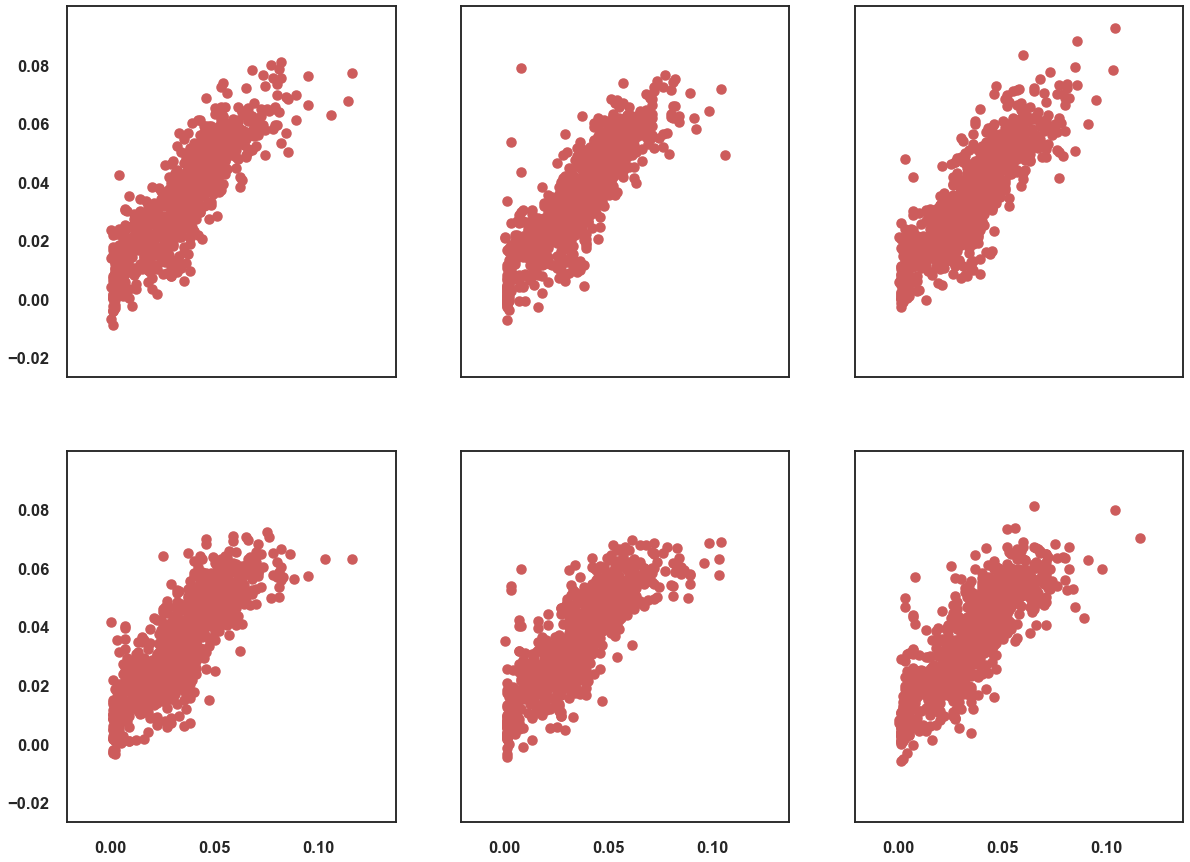

In [215]:
#plot actual vs. predicted ozone levels for all 8 hour segments
fig, ax = plt.subplots(2, 3, figsize=(20, 15), sharex = True, sharey = True)

plt.rc('xtick', labelsize=25) 
plt.rc('ytick', labelsize=25) 

ax[0,0].scatter(x = y_test['Ozone+8'], y = output['Ozone+8'], color = "indianred")
ax[0,1].scatter(y_test['Ozone+16'], output['Ozone+16'], color = "indianred")
ax[0,2].scatter(y_test['Ozone+24'], output['Ozone+24'], color = "indianred")
ax[1,0].scatter(y_test['Ozone+32'], output['Ozone+32'], color = "indianred")
ax[1,1].scatter(y_test['Ozone+40'], output['Ozone+40'], color = "indianred")
ax[1,2].scatter(y_test['Ozone+48'], output['Ozone+48'], color = "indianred")


plt.show

plt.savefig('model_scatter_pred_act.png')

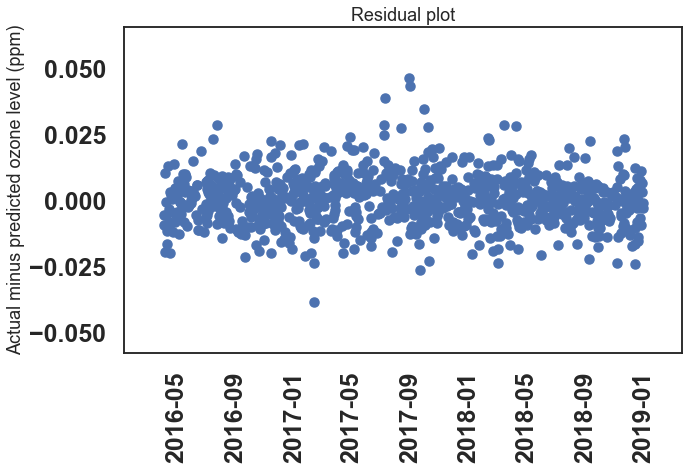

In [219]:
#check that residuals are scattered evenly

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(y_test.index, y_test['Ozone+8'] - output['Ozone+8'])
ax.set(title = 'Residual plot',
      ylabel = 'Actual minus predicted ozone level (ppm)')
plt.xticks(rotation=90)
plt.show()